Pruebas con Hamaus

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.cosmology import LambdaCDM
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.constants import G,c,M_sun,pc
from scipy.integrate import quad
from multiprocessing import Pool

In [2]:
h = 1.
Om0 = 0.3
cosmo = LambdaCDM(H0=100*h, Om0=Om0, Ode0=0.7)

In [3]:
def hamaus(r, Rs, delta, Rv, a, b):
    #rho_m = cosmo.critical_density(z).to('Msun/pc**3').value*Om0

    numerador = (1.-(r/Rs)**a)
    denominador = (1.+(r/Rv)**b)
    d   = delta*(numerador/denominador) 
    #rho = (1. + d)*rho_m

    return d

In [6]:
def hamaus2(r, ratio, delta, a, b):
    # ratio = Rs/Rv
    # Rs = 
    # numerador = 
    pass

In [9]:
z, Rv, delta, a, b = 0.3, 15., -0.8, 2.5, 5.
Rs = 0.8*Rv, 1.2*Rv
r = np.linspace(0., 3.*Rv, num = 100)
profile0 = hamaus(r,Rs[0],delta,Rv,a,b)
profile1 = hamaus(r,Rs[1],delta,Rv,a,b)


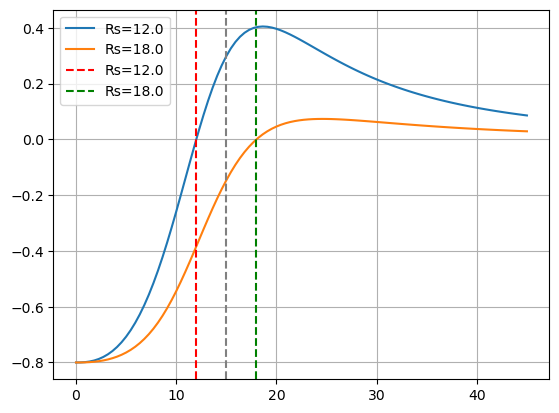

In [11]:
plt.plot(r,profile0, label=f'Rs={Rs[0]}')
plt.plot(r,profile1, label=f'Rs={Rs[1]}')

plt.axvline(Rv, c='gray', ls='--')
plt.axvline(Rs[0], c='red', ls='--', label=f'Rs={Rs[0]}')
plt.axvline(Rs[1], c='green', ls='--', label=f'Rs={Rs[1]}')

plt.grid(True)
plt.legend()
plt.show()


Pareciera que $R_s$ controla la amplitud de la pared $\rightarrow$ hagamos unos numeros

- Si $R_s > R_v \ \rightarrow$ la pared es pequeña : podriamos decir que está en un ambiente subdenso
- Si $R_s < R_v \ \rightarrow$ la pared es grande  : podriamos decir que está en un ambiente sobredenso


In [29]:
Rs = np.logspace(-1., 2., num=100)*Rv
r = np.linspace(0., 100., num = 100)*Rv
profiles = np.array([hamaus(r,rs,delta,Rv,a,b) for rs in Rs])

[]

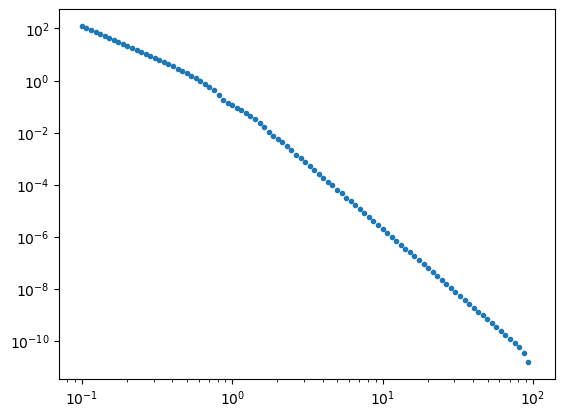

In [32]:
maximos = np.array([np.max(profiles[j]) for j,_ in enumerate(Rs)])
plt.plot(Rs/Rv,maximos, '.')
# plt.semilogy()
plt.loglog()

Veamos las proyecciones: $\Sigma$ y $\Delta \Sigma$

In [33]:
def sigma_hamaus(r,rs,delta,Rv,a,b):
    
    def integrand(z,R):
        return hamaus(np.sqrt(np.square(z)+np.square(R)),rs,delta,Rv,a,b)
  
    sigma = np.zeros_like(r)
    for j,x in enumerate(r):
        sigma[j] = quad(integrand, -np.inf, np.inf, args=(x,))[0]
    return sigma


In [34]:

def delta_sigma_hamaus(data,rs,delta,Rv,a,b):
    
    #r, Rv = data[:-1], data[-1]
    r = [data]
    # Rv = 1.
    
    def integrand(x):
        return sigma_hamaus([x],rs,delta,Rv,a,b)*x

    anillo = sigma_hamaus(r,rs,delta,Rv,a,b)
    disco = np.zeros_like(r)
    for j,p in enumerate(r):
        disco[j] = 2./p**2 * quad(integrand, 0., p)[0]

    return disco-anillo

def DSt_hamaus_unpack(kargs):
    return delta_sigma_hamaus(*kargs)

def DSt_hamaus_parallel(data,rs,delta,Rv,a,b):
    
    r, ncores = data[:-1], int(data[-1])
    partial = DSt_hamaus_unpack
    
    if ncores > len(r):
        ncores = len(r)
    
    lbins = int(round(len(r)/float(ncores), 0))
    slices = ((np.arange(lbins)+1)*ncores).astype(int)
    slices = slices[(slices < len(r))]
    Rsplit = np.split(r,slices)

    dsigma = np.zeros_like(r)
    dsigma = np.array_split(dsigma,slices)

    for j,r_j in enumerate(Rsplit):
        
        num = len(r_j)
        
        rs_arr    = np.full_like(r_j,rs)
        delta_arr = np.full_like(r_j,delta)
        Rv_arr    = np.full_like(r_j,Rv)
        a_arr     = np.full_like(r_j,a)
        b_arr     = np.full_like(r_j,b)
        
        entrada = np.array([r_j.T,rs_arr,delta_arr,Rv_arr,a_arr,b_arr]).T
                
        with Pool(processes=num) as pool:
            salida = np.array(pool.map(partial,entrada))
            pool.close()
            pool.join()
        
        dsigma[j] = salida
    
    dsigma = np.concatenate(dsigma,axis=0).flatten()

    return dsigma

In [35]:
z, Rv, delta, a, b = 0.3, 15., -0.8, 2.5, 5.
Rs = 0.8*Rv, 1.2*Rv
r = np.linspace(0., 3.*Rv, num = 100)
ncores = 2
data = np.append(r,ncores)
Sig0 = sigma_hamaus(r,Rs[0],delta,Rv,a,b)
Sig1 = sigma_hamaus(r,Rs[1],delta,Rv,a,b)

DSig0 = DSt_hamaus_parallel(data,Rs[0],delta,Rv,a,b)
DSig1 = DSt_hamaus_parallel(data,Rs[1],delta,Rv,a,b)

/tmp/ipykernel_15230/1492767450.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  disco[j] = 2./p**2 * quad(integrand, 0., p)[0]
/tmp/ipykernel_15230/1492767450.py:13: RuntimeWarning: invalid value encountered in double_scalars
  disco[j] = 2./p**2 * quad(integrand, 0., p)[0]
/tmp/ipykernel_15230/1492767450.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  disco[j] = 2./p**2 * quad(integrand, 0., p)[0]
/tmp/ipykernel_15230/1492767450.py:13: RuntimeWarning: invalid value encountered in double_scalars
  disco[j] = 2./p**2 * quad(integrand, 0., p)[0]


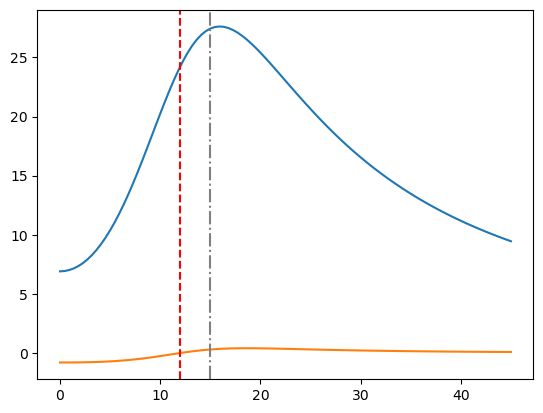

In [36]:
plt.plot(r,Sig0)
plt.plot(r,profile0)

plt.axvline(Rv, ls='-.', c='gray')
plt.axvline(Rs[0], ls='--', c='r')

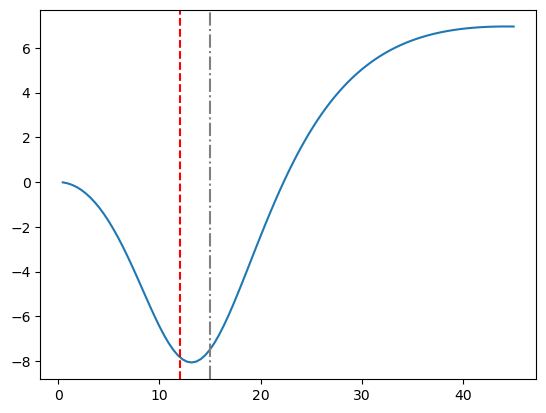

In [37]:
plt.plot(r,DSig0)
# plt.plot(r,profile0)

plt.axvline(Rv, ls='-.', c='gray')
plt.axvline(Rs[0], ls='--', c='r')

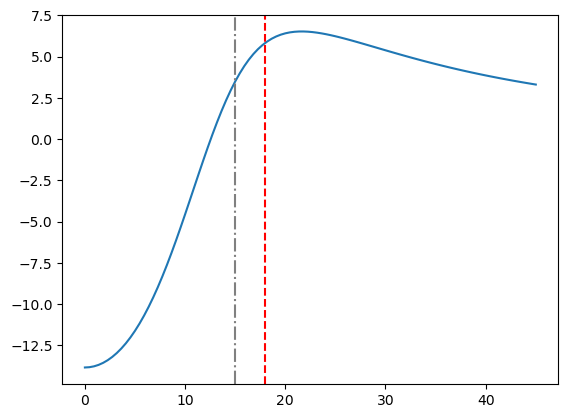

In [38]:
plt.plot(r,Sig1)
# plt.plot(r,profile1)

plt.axvline(Rv, ls='-.', c='gray')
plt.axvline(Rs[1], ls='--', c='r')

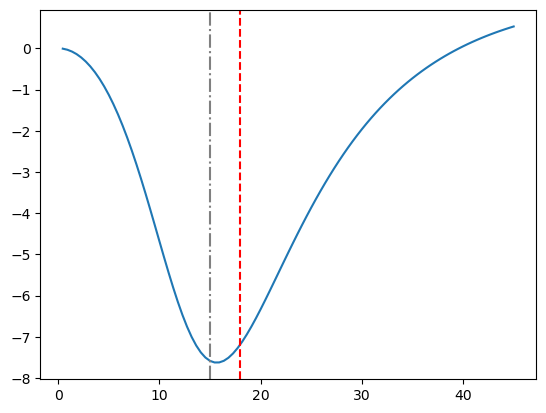

In [39]:
plt.plot(r,DSig1)
# plt.plot(r,profile1)

plt.axvline(Rv, ls='-.', c='gray')
plt.axvline(Rs[1], ls='--', c='r')

Intentemos realizar ajuste con emcee

In [42]:
import emcee

Text(0, 0.5, '$\\Sigma$')

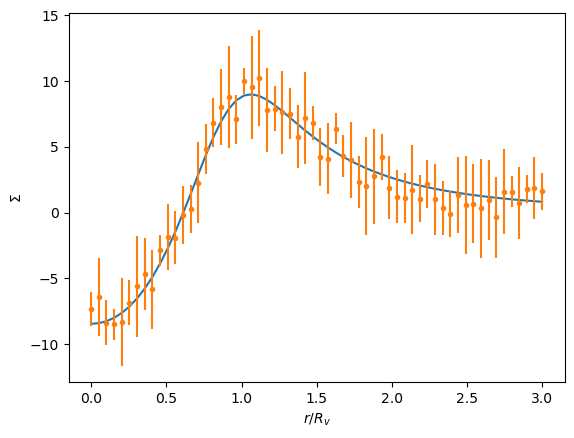

In [205]:
## hamaus paper:
rs_true    = 0.9  #Rs/Rv
delta_true = -0.7
a_true     = 3.
b_true     = 7.
rv_true    = 15.
N = 60
r = np.linspace(0.,3.*rv_true, num=N)

mu, sigma = 0., 1.
y_noise = np.random.normal(mu, sigma, N)

y_proy = sigma_hamaus(r,rs_true*rv_true,delta_true,rv_true,a_true,b_true)
y_proydata = y_proy + y_noise
yerr = np.full_like(y_proydata, sigma+3.*np.random.rand(N))

plt.plot(r/rv_true, y_proy)
plt.errorbar(r/rv_true,y_proydata,yerr,fmt='.')
plt.xlabel('$r/R_v$')
plt.ylabel('$\Sigma$')

In [234]:
def log_likelihood(theta, r, y, yerr):
    ## r y rs en unidades de Rv
    #rv = 1.
    rs,delta,rv,a,b = theta
    model = sigma_hamaus(r, rs*rv, delta, rv, a, b)
    sigma2 = yerr**2 + model**2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

def log_prior(theta):
    rs,delta,rv,a,b = theta
    if (0. < rs < 5.)&(-1. < delta < 0.)&(10. < rv < 30.)&(0. < a < 4.5)&(3. < b < 15.):
        return 0.0
    return -np.inf

def log_probability(theta, r, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, r, y, yerr)

In [245]:
# ndim = 5
# nwalkers = 15
# p0 = np.random.rand(nwalkers, ndim)

pos = np.array([0.6, -1., 10., 3., 10.]) + 1e-4 * np.random.randn(15, 5)
nwalkers, ndim = pos.shape


sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(r, y_proydata, yerr))
state = sampler.run_mcmc(pos, 100)
# sampler.reset()

In [250]:
import time
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(r,y_proydata,yerr), pool=pool)
    start = time.time()
    state = sampler.run_mcmc(pos, 100, progress=True)
    sampler.reset()
    sampler.run_mcmc(state, 10_000, progress=True)
    end = time.time()
    multi_time = end - start
print(multi_time)


/home/franco/miniconda3/envs/envpy/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/tmp/ipykernel_15230/1459569216.py:8: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  sigma[j] = quad(integrand, -np.inf, np.inf, args=(x,))[0]
/tmp/ipykernel_15230/1459569216.py:8: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  sigma[j] = quad(integrand, -np.inf, np.inf, args=(x,))[0]
/tmp/ipykernel_15230/1459569216.py:8: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  sigma[j] = quad(integrand, -np.inf, np.inf, args=(x,))[0]
/tmp/ipykernel_15230/1459569216.py:8: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  sigma[j] = quad(integrand, -np.inf, np.inf, args=(x,))[0]
/tmp/ipykernel_15230/1459569216.py:8: IntegrationWarning: The integral is probably divergent, or slowly c

3195.5277972221375


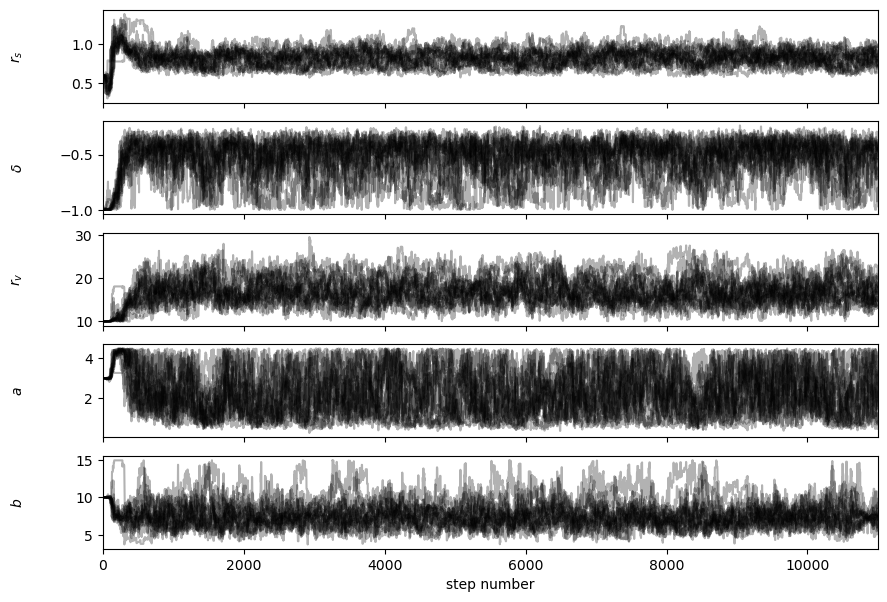

In [251]:
fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = [f'$r_s$', f'$\delta$', f'$r_v$',f'$a$', f'$b$']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [252]:
tau = sampler.get_autocorr_time()
print(tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 220;
tau: [196.31953107 180.7875732  233.58248009 204.56228979 203.7480461 ]

In [231]:
import corner

(10890, 5)


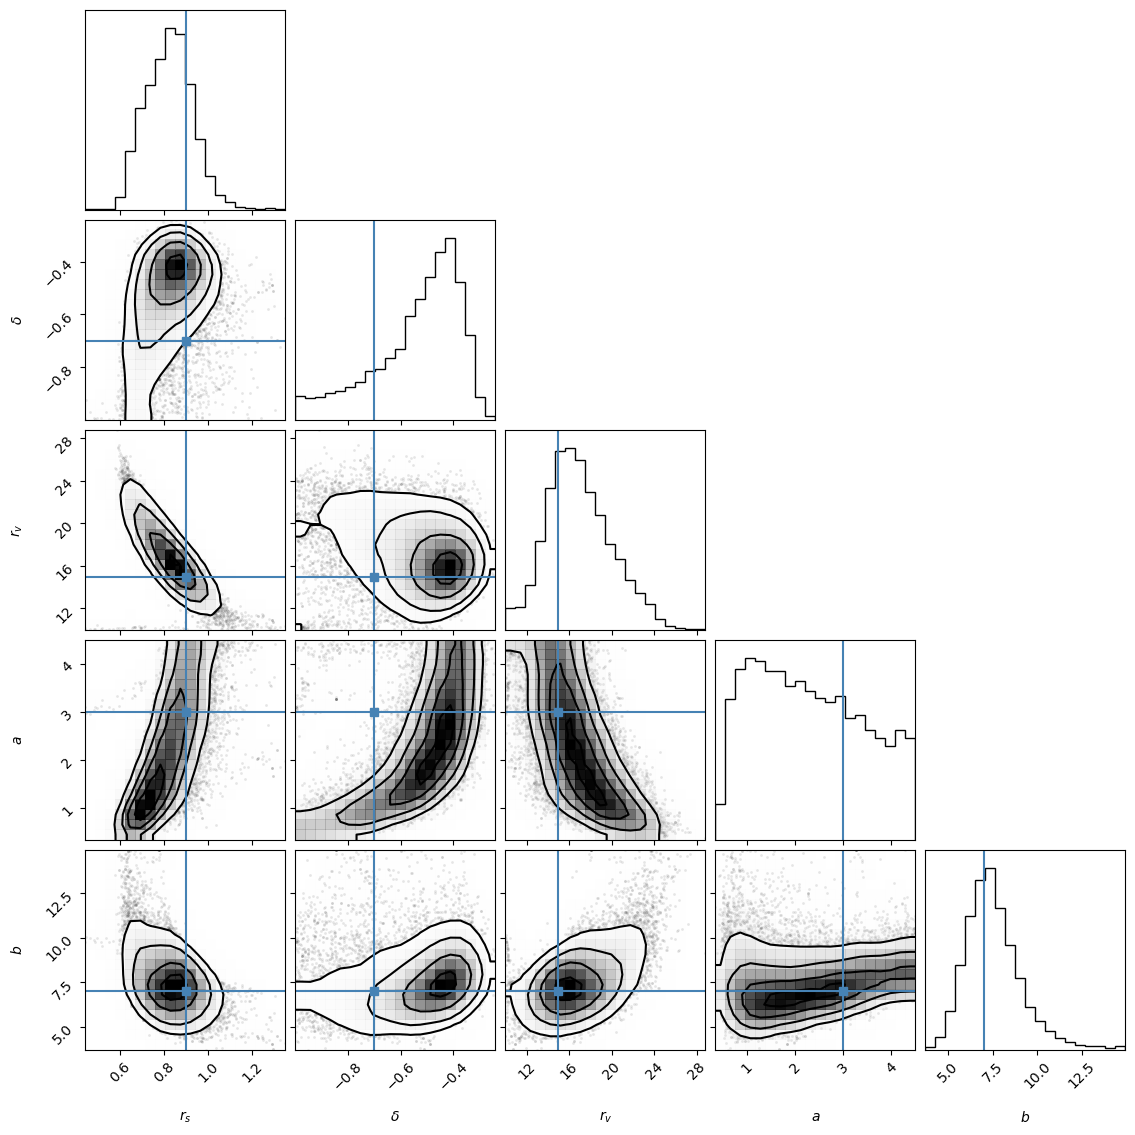

In [258]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

fig = corner.corner(
    flat_samples, labels=labels, truths=[rs_true, delta_true, rv_true,a_true, b_true], smooth=1.
);